# **Waze Project**

## Feature engineering

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv("waze_dataset_no_nans_no_incorrect_data.csv")

In [4]:
# from prev notebook

def get_median(datasource, column_title, round_to_n=1):
    return round(datasource[column_title].median(), round_to_n)

def get_mean(datasource, column_title, round_to_n=1):
    return round(datasource[column_title].mean(), round_to_n)

def print_central_tendency_metrics(datasource, column_title, round_to_n=1):
    median = get_median(datasource, column_title, round_to_n=round_to_n)
    mean = get_mean(datasource, column_title, round_to_n=round_to_n)
    print(f"{column_title}: median = {median}, mean = {mean}")

def boxplotter(datasource, column_title, plot_title=None, **kwargs):
    default_figure_size = (8,2)
    default_flier_size = 3
    plt.figure(figsize=default_figure_size)
    sns.boxplot(x=datasource[column_title], fliersize=default_flier_size)
    if not plot_title:
        plot_title = f'{column_title} box plot'
    plt.title(plot_title)
    
def histplotter(datasource, column_title, plot_title=None, **kwargs):                                                        
    median = get_median(datasource, column_title)
    plt.figure(figsize=(15,5))
    ax = sns.histplot(x=datasource[column_title], **kwargs)            
    plt.axvline(median, color='red', linestyle='--')
    plt.xlabel(column_title)
    plt.ylabel('count')
    if not plot_title:
        plot_title = f'{column_title} histogram'
    plt.title(plot_title)

def qqplotter(data, column_n, statistics, lower_bound=0):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dat = data[column_n].to_numpy()
    dat = dat[dat>lower_bound]
    print(dat.max)
    loc = statistics.fit(dat)
    print(f'fitted params are {loc}')
    stats.probplot(dat, dist=statistics, fit=True,plot=ax, sparams=(loc))
    plt.show()
    

#### **`km_per_driving_day`**

In [28]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()

count    10925.000000
mean       682.957016
std       1124.076334
min          3.022063
25%        168.775702
50%        319.407852
75%        662.486386
max      14867.817280
Name: km_per_driving_day, dtype: float64

Max value here is 14867 km, which, as we saw in the previous file, is impossible. However, 3Q value seems OK for someone who drives long distances every day

<built-in method max of numpy.ndarray object at 0x16905cc90>
fitted params are (1.0911118266226967, 2.4042944866985634, 349.4621405517601)


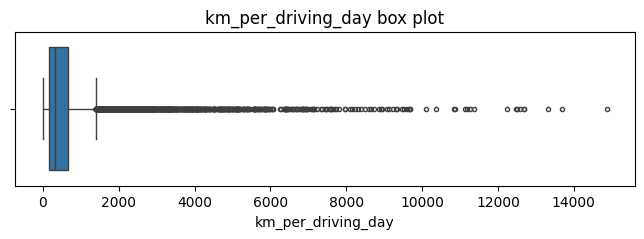

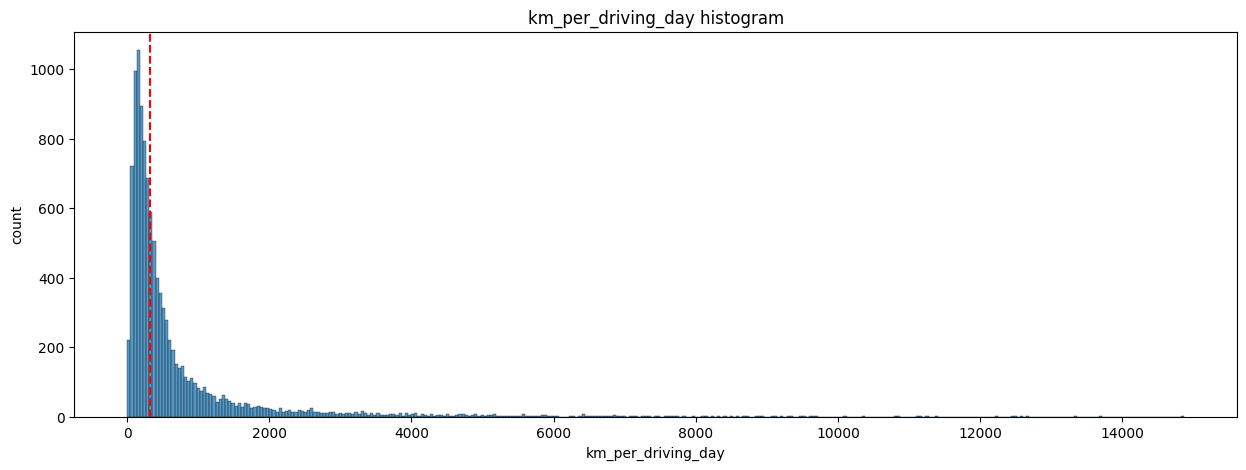

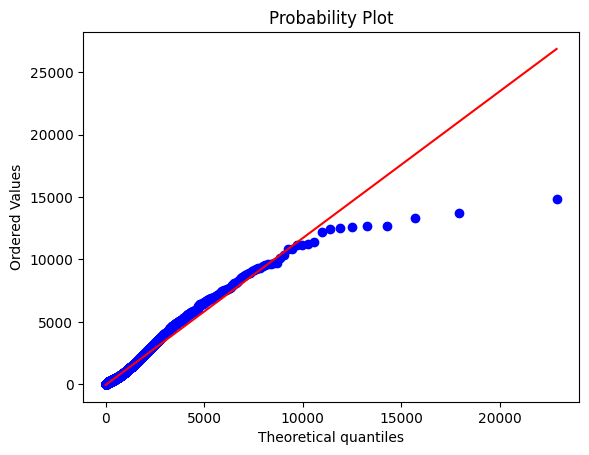

In [17]:
column = 'km_per_driving_day'
boxplotter(df, column)
histplotter(df, column)
qqplotter(df, column, stats.lognorm)

Even though the data is pretty well fitted on the probability plot, it is still not clear how a person can make thousands of kms per day. Can this be a data collection error? Or some users not closing the app on their journey for multiple days?

#### **`km_per_drive`**

This column shows the mean number of kilometers per drive made in the last month for each user.

In [18]:
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    10925.000000
mean       101.341372
std        175.592875
min          1.008775
25%         27.902017
50%         56.391229
75%        114.172609
max       5862.481732
Name: km_per_drive, dtype: float64

Max value is 5862 km per drive! Driving even at extreme 150 km/h, it would take 39 hours to complete this drive. It's unlikely that this could be real

<built-in method max of numpy.ndarray object at 0x16978cf30>
fitted params are (1.0555830983277716, 0.1792312191879524, 56.59081943171016)


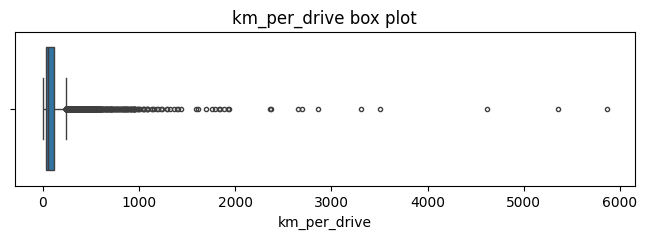

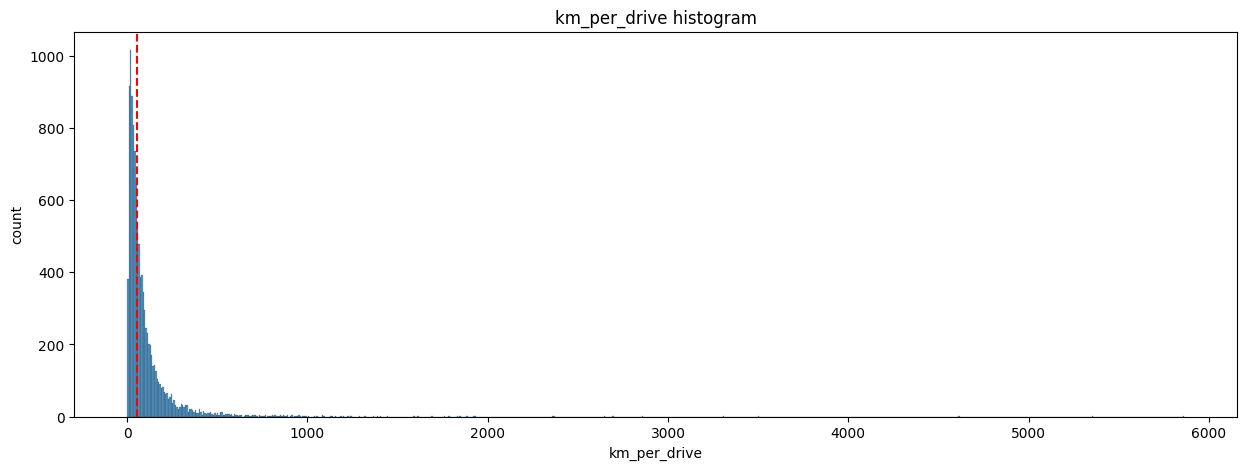

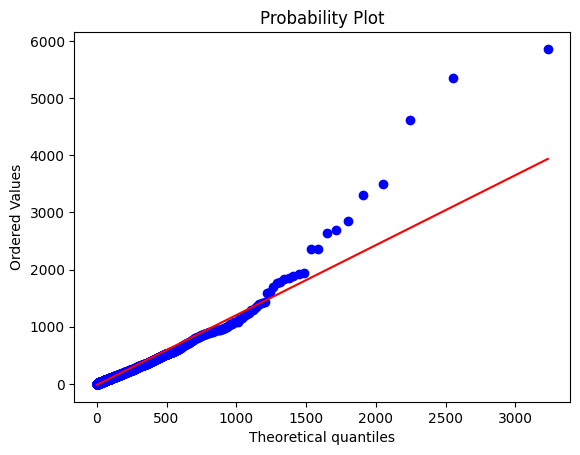

In [19]:
column = 'km_per_drive'
boxplotter(df, column)
histplotter(df, column)
qqplotter(df, column, stats.lognorm)

#### **`drives_per_driving_day`**

At the previous stage, it turned out that some users complete a lot of drives. Let's use it as a feature

In [11]:
df['drives'].describe()

count    10925.000000
mean        80.366407
std         66.730635
min          1.000000
25%         34.000000
50%         61.000000
75%        106.000000
max        596.000000
Name: drives, dtype: float64

In [20]:
df['drives_per_driving_day'] = df['drives'] / df['driving_days']

In [21]:
df.loc[df['drives_per_driving_day']==np.inf, 'drives_per_driving_day'] = 0
df['drives_per_driving_day'].describe()

count    10925.000000
mean        12.125710
std         21.847025
min          1.000000
25%          2.833333
50%          5.533333
75%         11.625000
max        395.000000
Name: drives_per_driving_day, dtype: float64

<built-in method max of numpy.ndarray object at 0x13fe3c8d0>
fitted params are (1.3383114118202057, 0.8979587858214354, 4.588604915004754)


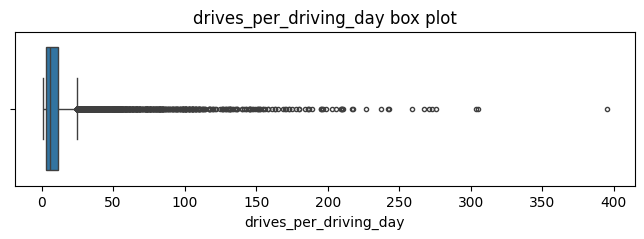

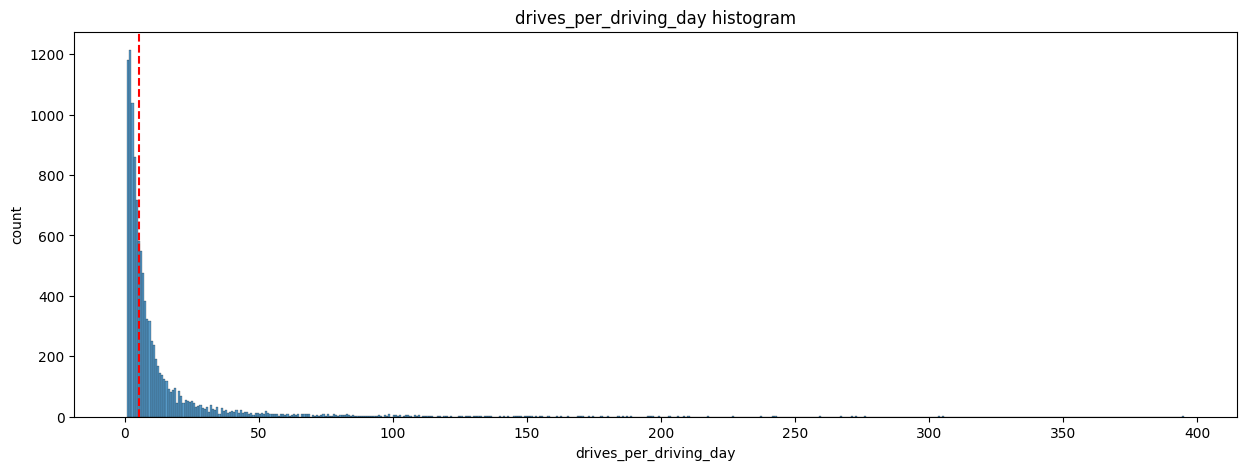

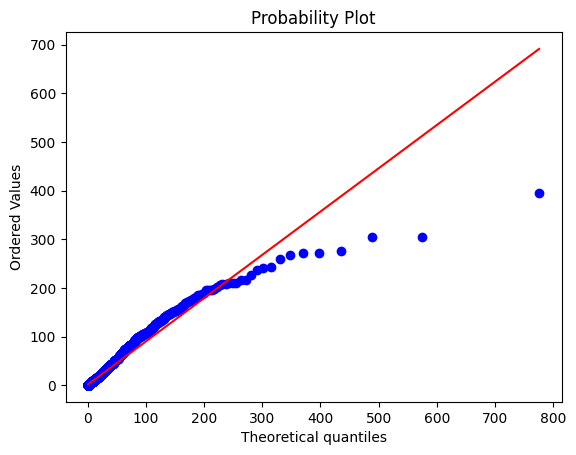

In [22]:
column = 'drives_per_driving_day'
boxplotter(df, column)
histplotter(df, column)
qqplotter(df, column, stats.lognorm)

This is an interesting finding. There are entries with A LOT of drives per driving day, with the maximum of 395 (!).
Some users who completed more than 200 drives did that in just one or two driving days (!) and drove several thousand km. This is probably physically impossible.

It would be great if it was possible to get some elaboration on this data from the stakeholders.

In [32]:
df[df['drives_per_driving_day'] >= 200]

,Unnamed: 0,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,drives_per_driving_day,km_per_drive,session_per_activity_day
48,63,63,retained,253,203,298.673647,1546,0,88,4695.169432,2146.467081,6,1,iPhone,4695.169432,203.0,23.128913,42.166667
276,376,376,churned,256,209,387.088693,2707,0,0,3309.863745,660.564362,1,1,iPhone,3309.863745,209.0,15.836669,256.000000
344,472,472,churned,250,209,257.054881,1341,139,19,10828.244390,4322.142842,1,1,Android,10828.244390,209.0,51.809782,250.000000
1466,1978,1978,retained,262,210,302.915904,1088,20,0,5268.853194,2312.041030,6,1,iPhone,5268.853194,210.0,25.089777,43.666667
1798,2445,2445,retained,323,259,375.045901,2793,43,35,4949.591318,747.623435,1,1,Android,4949.591318,259.0,19.110391,323.000000
1903,2583,2583,churned,338,271,362.135032,508,128,48,12691.386240,1296.527153,5,1,iPhone,12691.386240,271.0,46.831684,67.600000
2250,3057,3057,churned,522,435,659.094737,355,0,120,5562.202041,2167.486429,4,2,iPhone,2781.101020,217.5,12.786671,130.500000
2287,3106,3106,retained,272,217,294.646403,1099,319,23,4070.204693,870.903275,5,1,iPhone,4070.204693,217.0,18.756704,54.400000
3359,4616,4616,retained,339,273,365.312848,1761,310,18,4065.961787,2501.688159,1,1,iPhone,4065.961787,273.0,14.893633,339.000000
3499,4806,4806,retained,337,305,426.923922,1338,0,5,1167.154002,451.280651,6,1,Android,1167.154002,305.0,3.826734,56.166667


### Let's cut some extreme data values based on the distributions:

In [43]:
df_no_extremes = df[df["drives_per_driving_day"] < 200]
df_no_extremes = df_no_extremes[df_no_extremes["km_per_drive"] < 2000]

In [46]:
df_no_extremes.shape

(10894, 18)

In [48]:
df = df_no_extremes

#### **`sessions_per_activity_day`**

This column shows the mean number of sessions per activity day logged in the last month for each user.

In [52]:
df['sessions_per_activity_day'] = df['sessions'] / df['activity_days']
df.loc[df['sessions_per_activity_day']==np.inf, 'sessions_per_activity_day'] = 0
df['sessions_per_activity_day'].describe()

count    10894.000000
mean        10.138842
std         17.671799
min          1.000000
25%          2.592593
50%          5.000000
75%         10.236264
max        249.000000
Name: sessions_per_activity_day, dtype: float64

<built-in method max of numpy.ndarray object at 0x169fb2b50>
fitted params are (1.3144530079023609, 0.8816466295478369, 3.962148847083424)


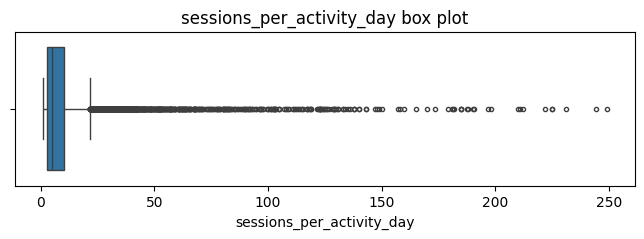

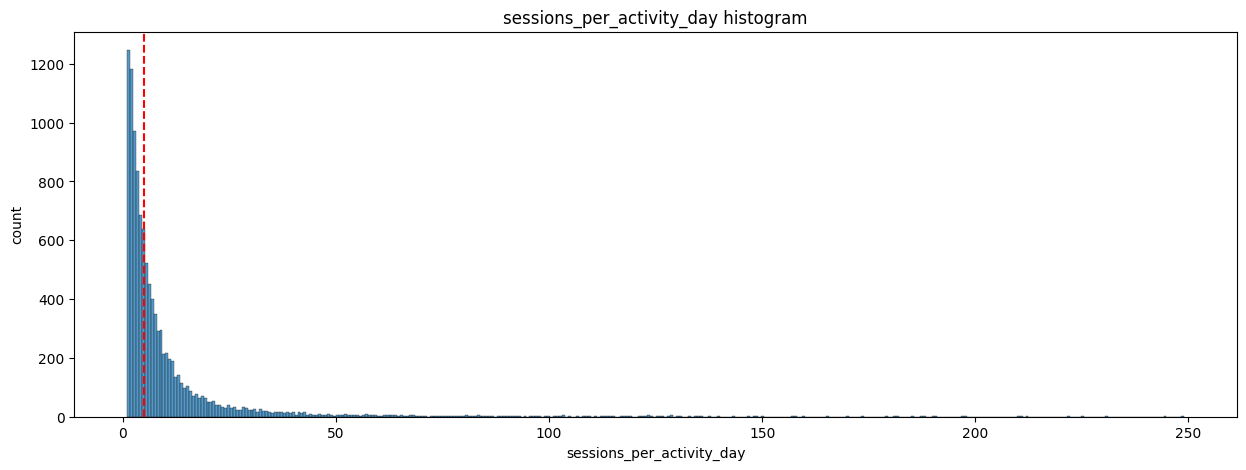

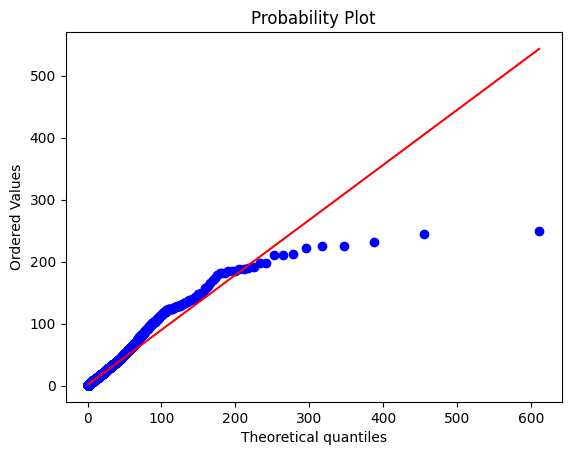

In [53]:
column = 'sessions_per_activity_day'
boxplotter(df, column)
histplotter(df, column)
qqplotter(df, column, stats.lognorm)

Once again, this value is heavily skewed to the right and its max values are very big.

In [55]:
df.drop(df[df["sessions_per_activity_day"] > 200].index, inplace=True)

## Variable encoding

#### **Target encoding**

In [56]:
df['is_churned'] = np.where(df['label'] == 'churned', 1, 0)

In [57]:
df.drop(columns = ['label'], inplace=True)

#### **Dummying features**

The only categorical feature remaining is the device, we can get dummies for it.

In [58]:
df["device_code"] = np.where(df["device"] == "iPhone", 1, 2)

In [59]:
df.drop(columns = ["device"], inplace=True)

In [89]:
df.head()

,Unnamed: 0,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,drives_per_driving_day,km_per_drive,is_churned,device_code
0,0,0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,11.894737,11.632058,0,2
1,1,1,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,1246.901868,9.727273,128.186173,0,1
2,2,2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,11.875000,32.201567,0,2
3,3,3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,13.333333,22.839778,0,1
4,4,4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,3.777778,58.091206,0,2


In [60]:
df.to_csv('dataset_encoded_features.csv')

## Conclusion

While trying to engineer helpful features, I discovered values that raised reasonable suspicion:
- extremely long averaged distances per drive
- extremely high averaged values of the number of drives per driving day and sessions per activity day

While, in my opinion, this might indicate two different groups of drivers: 1) long-haul drivers or travellers and 2) taxi/delivery drivers making lots of drives daily. Their patterns of usage need further research, and insights from stakeholders will be very important. However, some of such values do not seem physically possible. So it is crucial to discuss possible errors in the data and also learn how to establish proper thresholds.